In [1]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import pandas as pd

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
import scienceplots

plt.style.use(['science', 'grid', 'high-vis'])

# seed the random number generator
rstate = np.random.default_rng(113)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 15})
rcParams.update({'figure.dpi': 300})

In [3]:
import dynesty
import GPy
import celerite
from celerite import terms
from eztao.ts import neg_param_ll, sample_carma, carma_fit, dho_fit
from eztao.carma import CARMA_term, DHO_term, DRW_term
from scipy.optimize import minimize


plt.rc('axes', unicode_minus=False)

### Red noise (real LC):

$$ y(t) = \sum \Delta t \cdot dist $$

where $ dist \sim N(0, \sigma)$

### Tick-tock signal:

$$ y(t) = A(t) \sin (2\pi ~f(t) ~t) $$

where $ A(t) = \exp(-gt) $, $g$ is the amplitude damping factor, and $f(t) = \frac{\exp(ht)}{T_{init}}$, $h$ being the frequency damping factor and $T_{init}$ the initial period.

Q: Can we use `dynesty` to get posteriors for $g$, $h$, and $T_{init}$ and maybe even $\sigma$ for the tick-tock signal?

In [4]:
E1821 = pd.read_csv('Shap+16.txt', sep='|', index_col=0)
E1821

,Date,JD,seeing,Rmag,e_Rmag,Vmag,e_Vmag,Bmag,e_Bmag
Seq,,,,,,,,,
1,28 06 2003,52818.4,3.0,13.964,0.027,15.230,0.030,14.413,0.015
2,30 06 2003,52820.5,3.0,13.965,0.036,15.212,0.028,14.431,0.014
3,31 07 2003,52852.4,2.0,13.956,0.028,15.232,0.008,14.420,0.009
4,26 08 2003,52877.4,2.3,13.980,0.036,15.276,0.029,14.430,0.026
5,01 10 2003,52913.4,1.8,13.967,0.036,15.283,0.014,14.443,0.029
...,...,...,...,...,...,...,...,...,...
94,23 05 2014,56801.5,1.5,13.732,0.026,14.945,0.013,14.115,0.030
95,28 07 2014,56867.4,1.7,13.774,0.013,14.969,0.033,14.140,0.026
96,22 09 2014,56923.3,2.5,13.775,0.020,15.000,0.028,14.154,0.017


In [5]:
E1821.Rmag.values[5] = 'NaN'
E1821.Rmag.values[39] = 'NaN'
E1821.e_Rmag.values[5] = 'NaN'
E1821.e_Rmag.values[39] = 'NaN'

In [6]:
E1821.JD = E1821.JD.astype('float64')
E1821.Rmag = E1821.Rmag.astype('float64')
E1821.Vmag = E1821.Vmag.astype('float64')
E1821.Bmag = E1821.Bmag.astype('float64')
E1821.e_Rmag = E1821.e_Rmag.astype('float64')
E1821.e_Vmag = E1821.e_Vmag.astype('float64')
E1821.e_Bmag = E1821.e_Bmag.astype('float64')

In [7]:
E1821 = E1821.dropna(how='any')
E1821

,Date,JD,seeing,Rmag,e_Rmag,Vmag,e_Vmag,Bmag,e_Bmag
Seq,,,,,,,,,
1,28 06 2003,52818.4,3.0,13.964,0.027,15.230,0.030,14.413,0.015
2,30 06 2003,52820.5,3.0,13.965,0.036,15.212,0.028,14.431,0.014
3,31 07 2003,52852.4,2.0,13.956,0.028,15.232,0.008,14.420,0.009
4,26 08 2003,52877.4,2.3,13.980,0.036,15.276,0.029,14.430,0.026
5,01 10 2003,52913.4,1.8,13.967,0.036,15.283,0.014,14.443,0.029
...,...,...,...,...,...,...,...,...,...
94,23 05 2014,56801.5,1.5,13.732,0.026,14.945,0.013,14.115,0.030
95,28 07 2014,56867.4,1.7,13.774,0.013,14.969,0.033,14.140,0.026
96,22 09 2014,56923.3,2.5,13.775,0.020,15.000,0.028,14.154,0.017


In [ ]:
E1821.to_csv('E1821+643.csv', sep=',')

Text(0.5, 1.0, 'R-band magnitude of E1821+643')

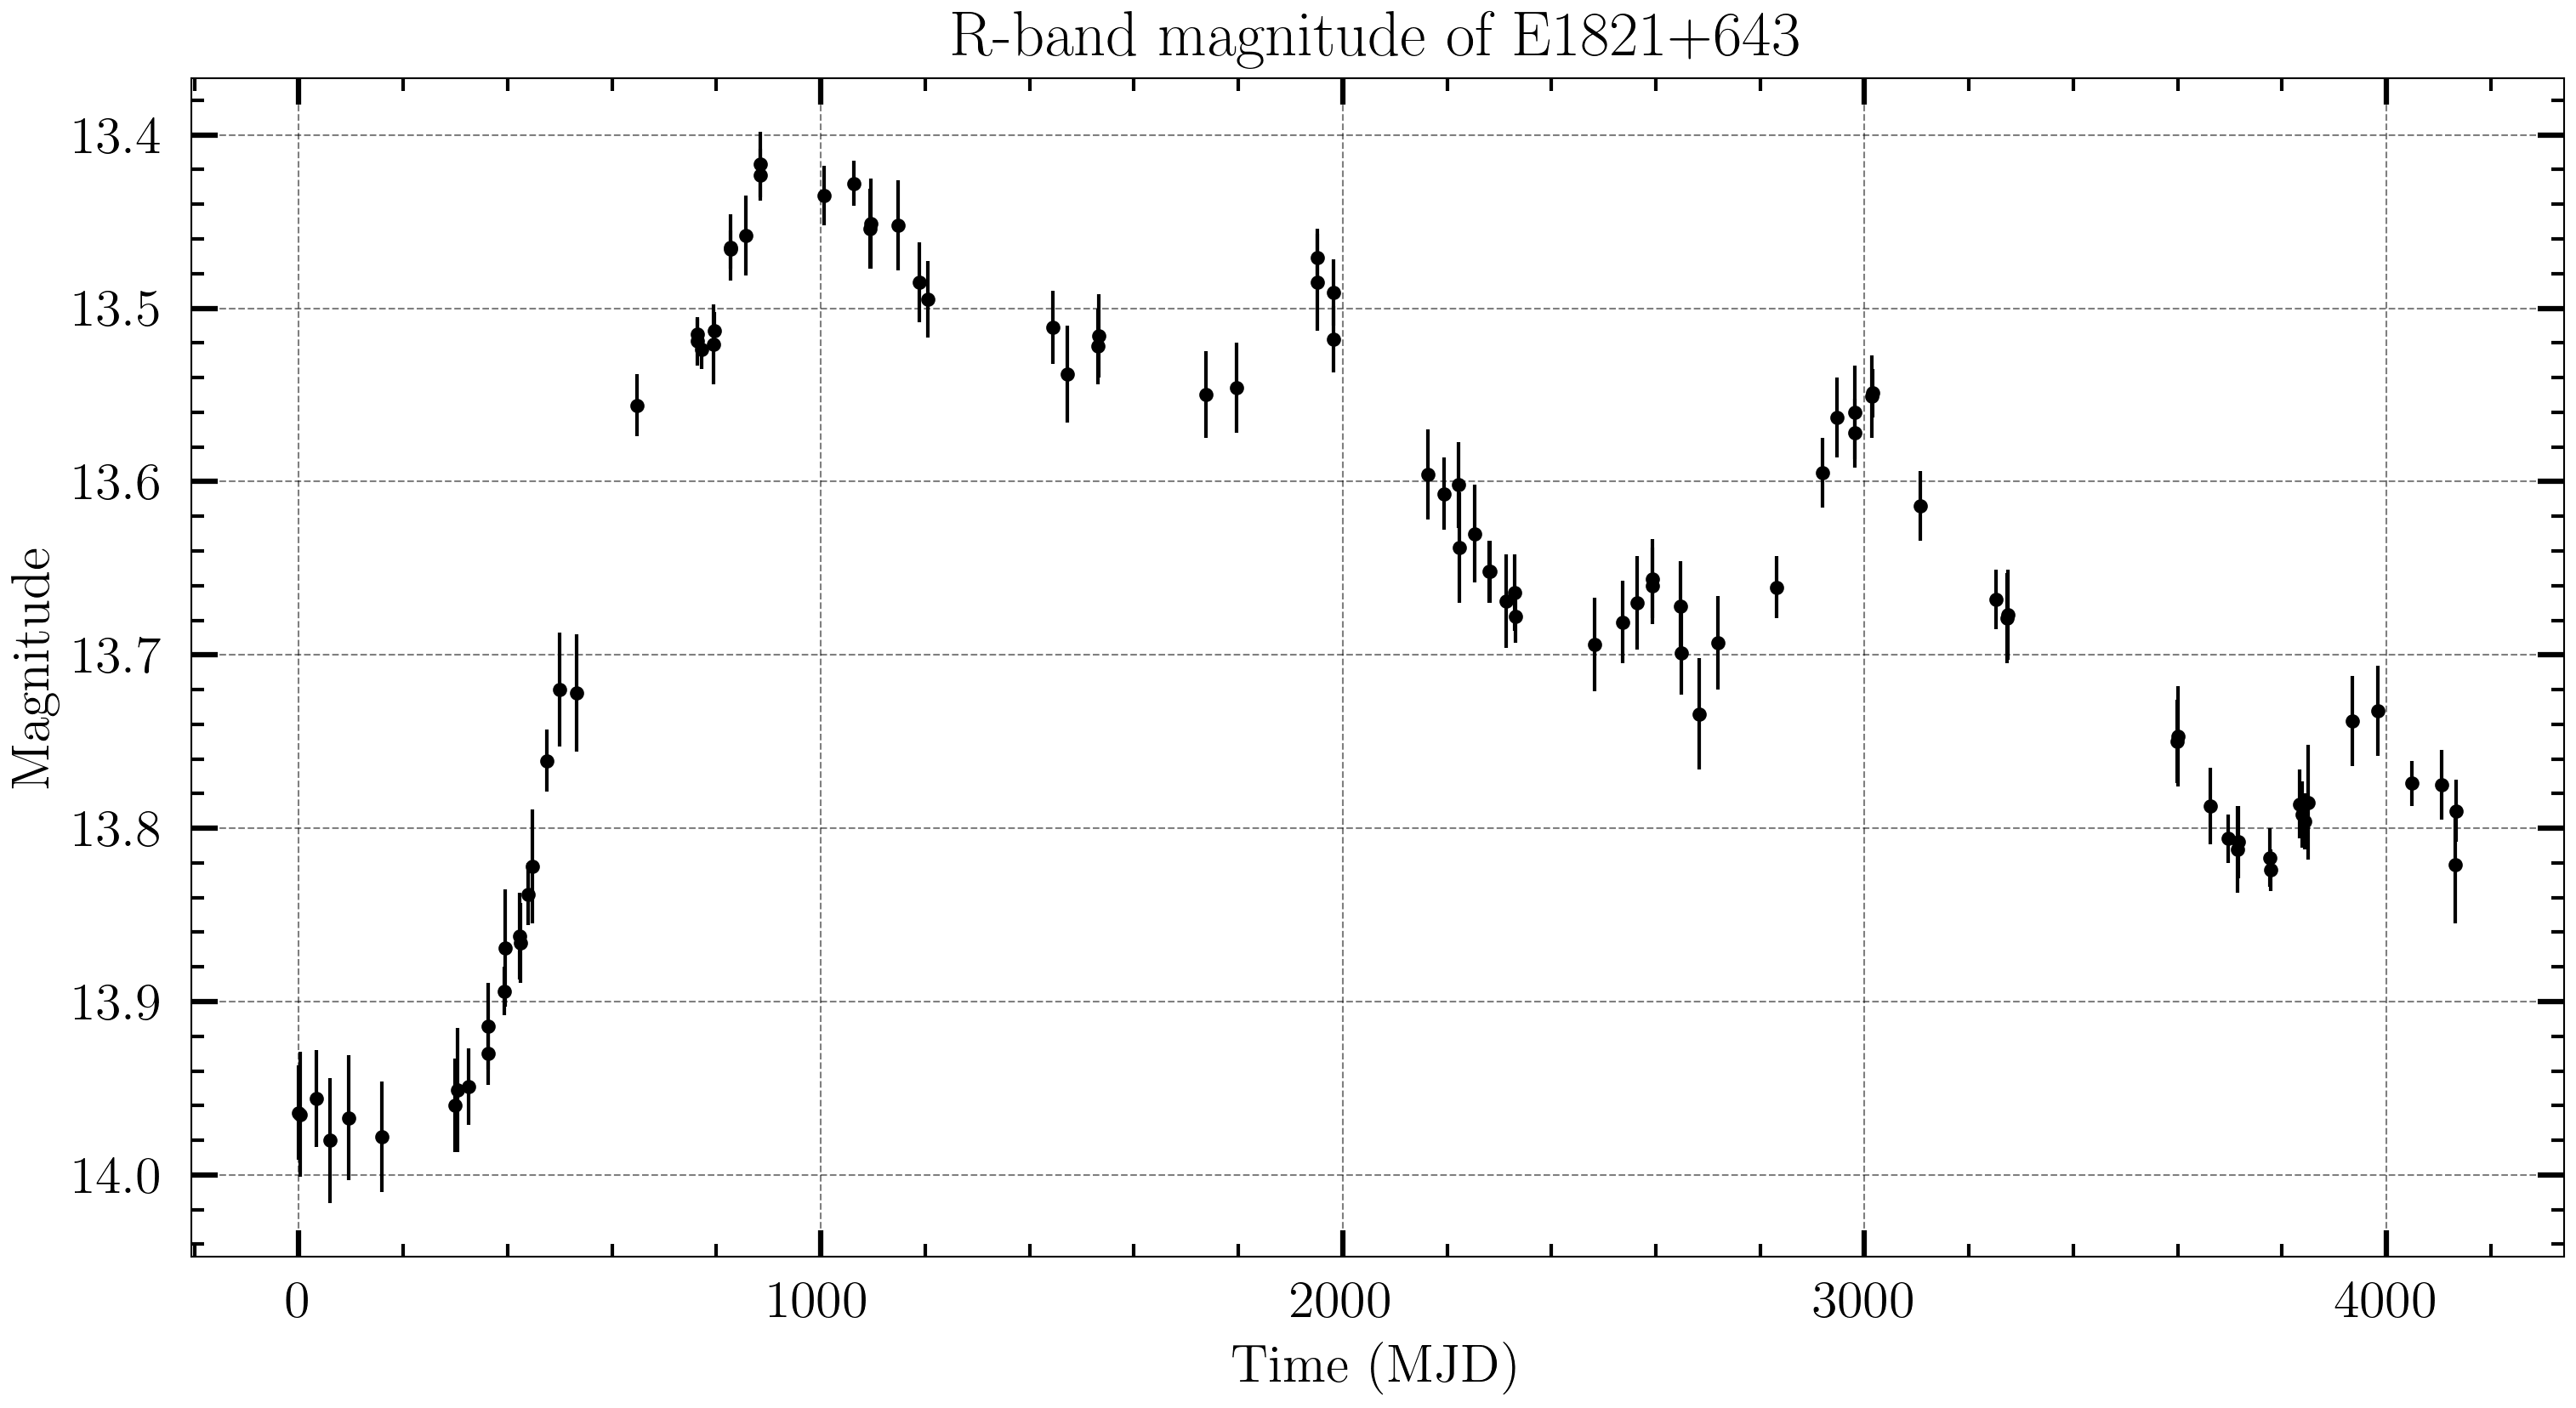

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.errorbar(E1821.JD.values - E1821.JD.values.min(), E1821.Rmag.values, yerr=E1821.e_Rmag.values, fmt='k.')
plt.gca().invert_yaxis()
plt.xlabel(r'Time (MJD)')
plt.ylabel(r'Magnitude')
plt.title(r'R-band magnitude of E1821+643')

## Testing EzTao and Celerite

In [10]:
E1821_days = E1821.JD.values - E1821.JD.values.min()

# Define the celerite model (replace this with your specific model)
dho_init_params = [1.0, 1.0, 1.0, 1.0]
dho_kernel = DHO_term(*dho_init_params) # log_a1, log a2, log b0, log b2
cel_kern = terms.SHOTerm(log_S0=0.0, log_Q=0.0, log_omega0=-2.0)
# cel_kern2 = terms
drw_init_params = [1.0, 1.0]
drw_kernel = DRW_term(*drw_init_params)

gp = celerite.GP(kernel=cel_kern+drw_kernel)
gp.compute(E1821_days, yerr=E1821.e_Rmag.values)

In [ ]:
sample = np.linspace(0,100,1000)

plt.figure(figsize=(12,12))
plt.imshow(gp.get_matrix(sample), cmap='gray')

In [11]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
# bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(E1821.Rmag.values, gp))
gp.set_parameter_vector(r.x)
print(r)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -109.1023033657088
        x: [-1.290e+00 -1.260e+00 -4.158e+00  8.023e+00  3.201e+01]
      nit: 9
      jac: [-6.252e+01 -4.402e+01 -3.963e+01 -1.374e+02  0.000e+00]
     nfev: 78
     njev: 13
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


Text(0.5, 1.0, 'R-band magnitude of E1821+643')

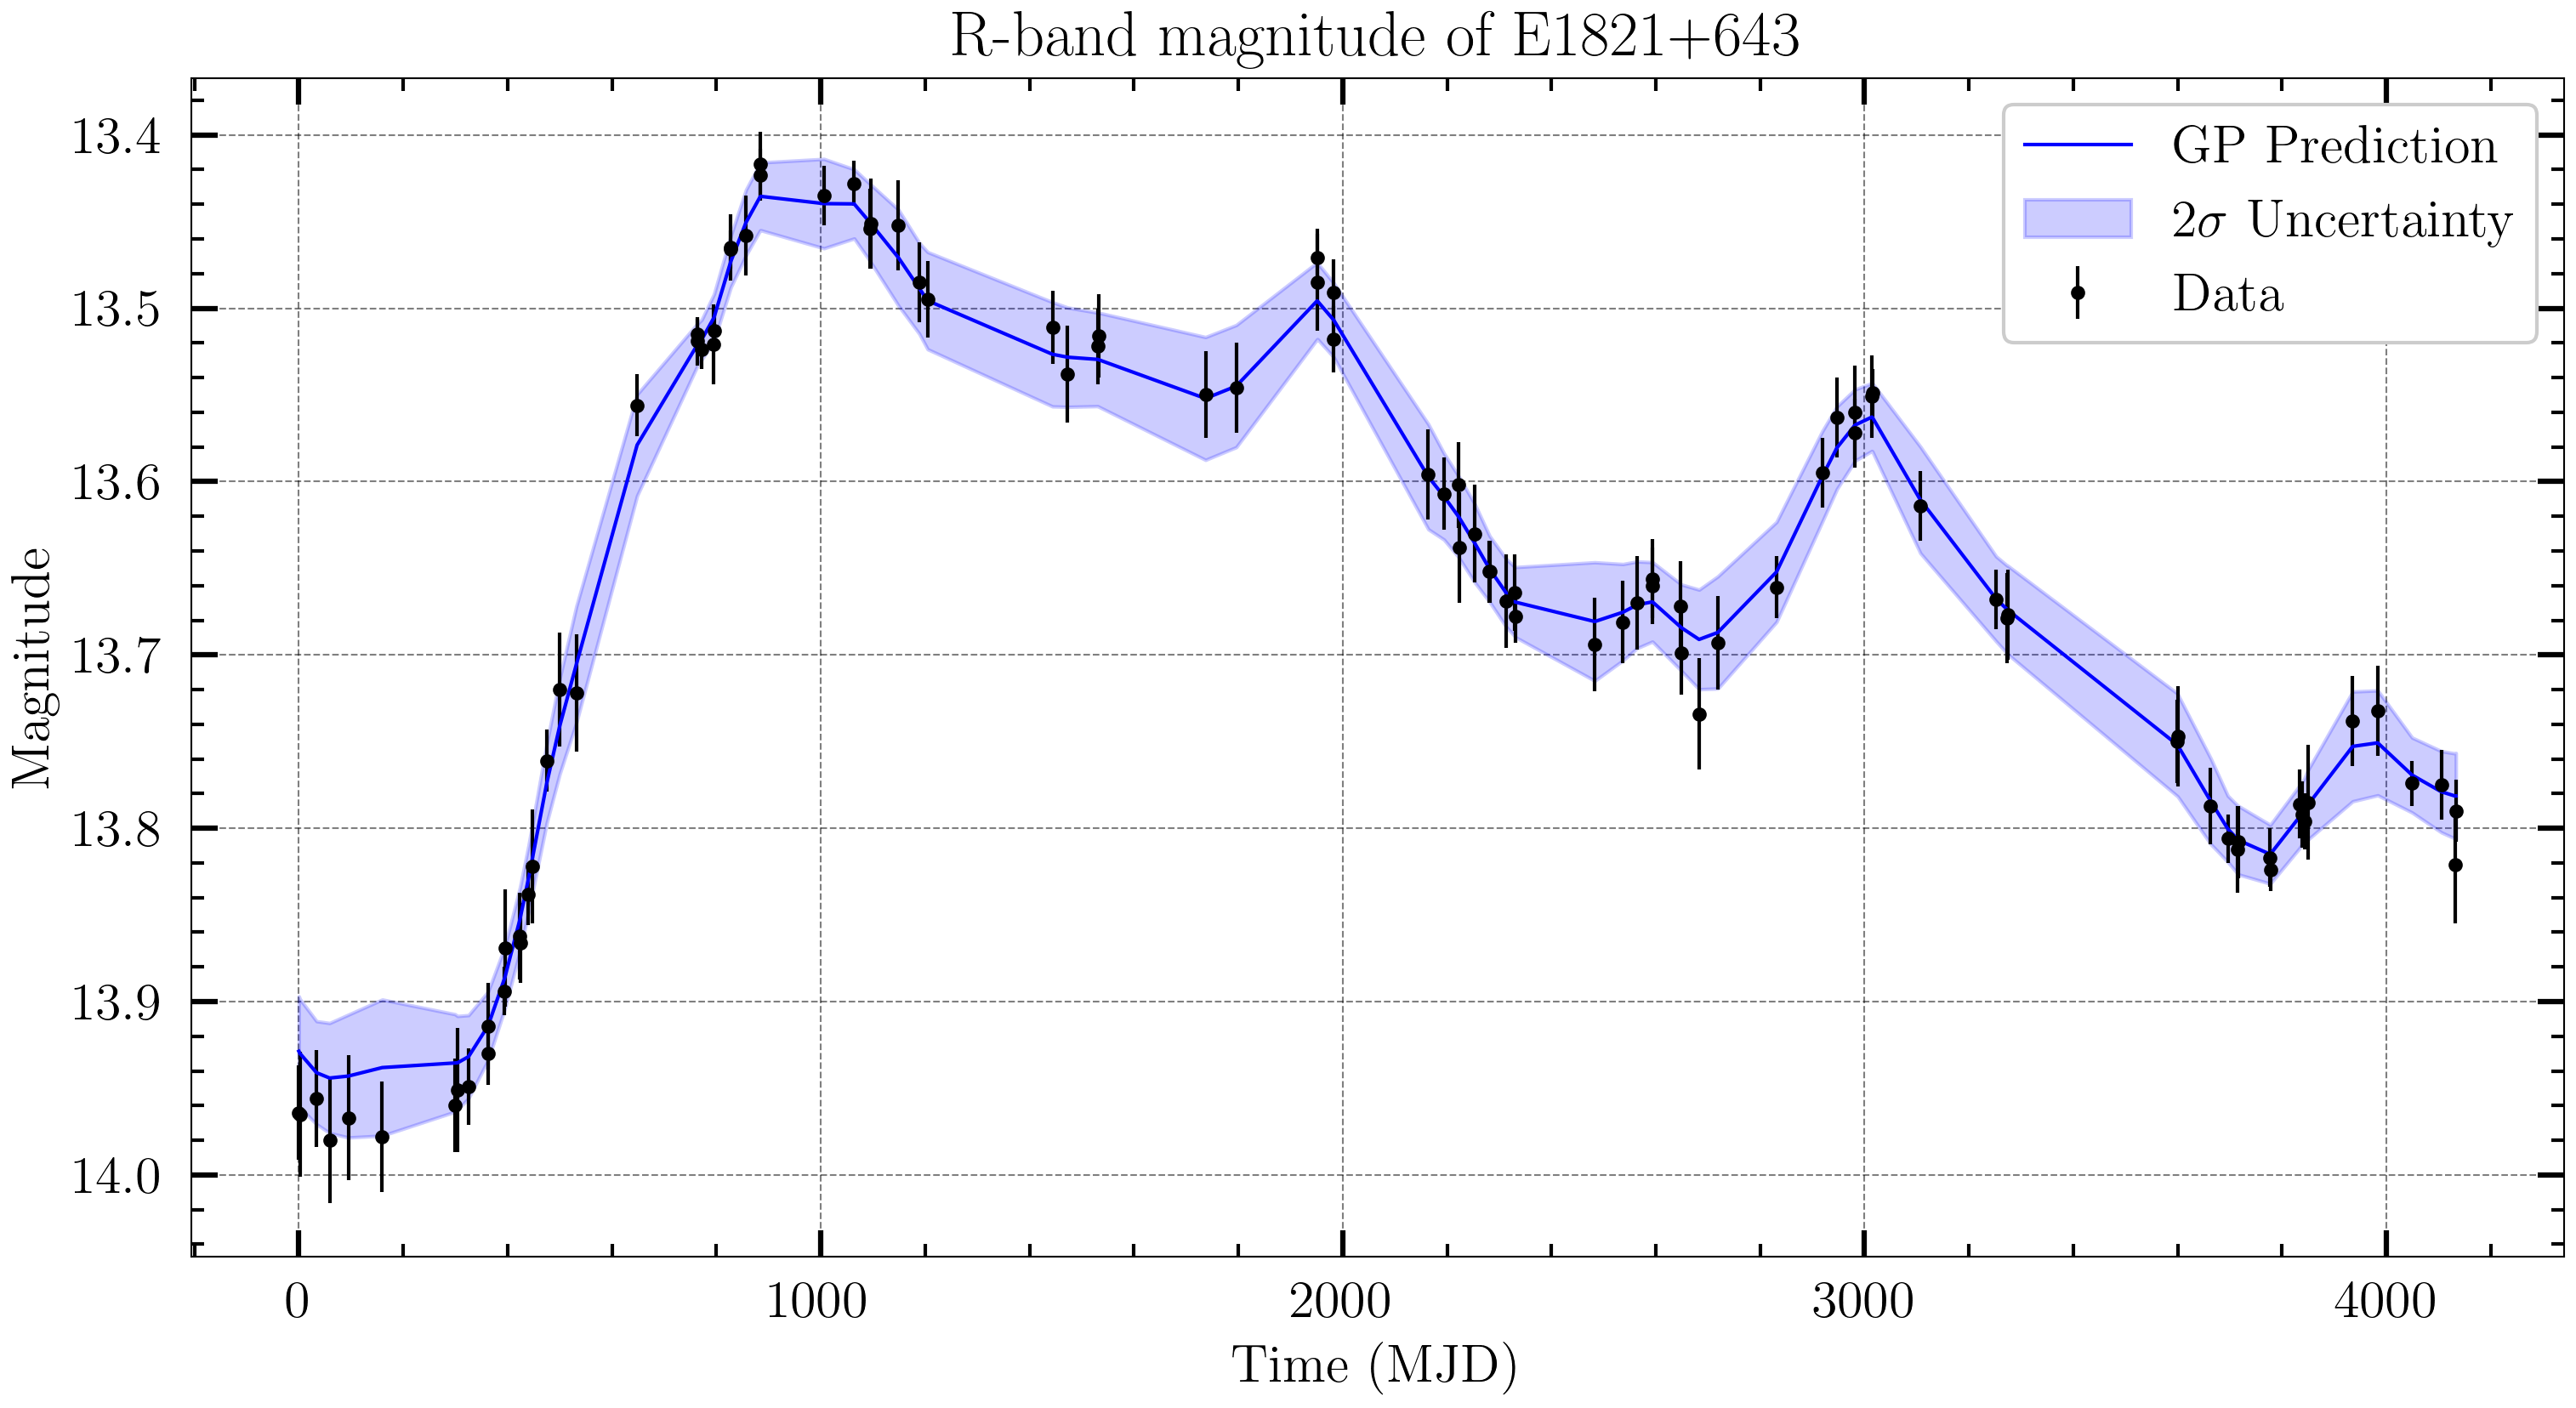

In [12]:
pred_mean, pred_var = gp.predict(E1821.Rmag.values, return_var=True)

plt.figure(figsize=(12,6))
# Plot the data
plt.errorbar(E1821_days, E1821.Rmag.values, yerr=E1821.e_Rmag.values, fmt='.k', capsize=0, label='Data')

# Plot the GP prediction
plt.plot(E1821_days, pred_mean, label='GP Prediction', color='blue')

# Plot the original tick-tock signal
# plt.plot(real_times, trial, 'r--', label='Original function')

# Shade the uncertainty region
plt.fill_between(E1821_days, pred_mean - 2*np.sqrt(pred_var), pred_mean + 2*np.sqrt(pred_var), color='blue', alpha=0.2, label=r'$2\sigma$ Uncertainty')

plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.xlabel(r'Time (MJD)')
plt.ylabel(r'Magnitude')
plt.title(r'R-band magnitude of E1821+643')

In [13]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -1.2898241198557743),
             ('kernel:terms[0]:log_Q', -1.2599504520575922),
             ('kernel:terms[0]:log_omega0', -4.158106558159411),
             ('kernel:terms[1]:log_amp', 8.023475928160192),
             ('kernel:terms[1]:log_tau', 32.00829711074874)])

In [ ]:
######################### EzTao ############################
from scipy.stats import norm

# Define the log-likelihood function
def log_likelihood(params, y, gp):
    gp.kernel.set_parameter_vector(params)

    # Compute the log likelihood
    return gp.log_likelihood(y)

# Define the prior transform
def ptform(u):
    """
    Transforms from u~[0,1) to parameter space of interest
    """
    uloga1, uloga2, ulogb0, ulogb1, ulogamp, ulogtau = u
    
    loga1 = norm.ppf(uloga1, loc=2.19)
    loga2 = norm.ppf(uloga2, loc=0.63)
    logb0 = norm.ppf(ulogb0, loc=0.9)
    logb1 = norm.ppf(ulogb1, loc=-0.85)
    logamp = norm.ppf(ulogamp, loc=6.88)
    logtau = norm.ppf(ulogtau, loc=26.3)

    
    return loga1, loga2, logb0, logb1, logamp, logtau

In [14]:
######################### celerite ############################
from scipy.stats import norm

# Define the log-likelihood function
def log_likelihood(params, y, gp):
    gp.kernel.set_parameter_vector(params)

    # Compute the log likelihood
    return gp.log_likelihood(y)

# Define the prior transform
def ptform(u):
    """
    Transforms from u~[0,1) to parameter space of interest
    """
    ulogS0, ulogQ, ulogomega0, ulogamp, ulogtau = u
#     logS0 = (ulogS0 - 2) # log s0 = [-5, 5]
#     logQ = (ulogQ - 2)
#     logomega0 = 5*(ulogomega0 - 1.5)
#     logamp = 5*(ulogamp*2 + 1)
#     logtau = 10*(ulogtau*2 + 2)
    logS0 = norm.ppf(ulogS0, loc=-1.3)
    logQ = norm.ppf(ulogQ, loc=-1.3)
    logomega0 = norm.ppf(ulogomega0, loc=-4.15)
    logamp = norm.ppf(ulogamp, loc=8.02)
    logtau = norm.ppf(ulogtau, loc=32.0)

    
    return logS0, logQ, logomega0, logamp, logtau

In [15]:
################# Celerite ######################
# sampler for evidence estimation
sampler_cel = dynesty.DynamicNestedSampler(log_likelihood, ptform, ndim=5,
                                bound='multi', sample='rslice',
                               rstate=rstate, logl_args=(E1821.Rmag.values, gp))
sampler_cel.run_nested()
res_cel = sampler_cel.results

0it [00:00, ?it/s] /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/sampler.py:746: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1350: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1351: RuntimeWarning:underflow encountered in logaddexp
9453it [04:50, 256.64it/s, batch: 0 | bound: 49 | nc: 1 | ncall: 386741 | eff(%):  2.442 | loglstar:   -inf < 198.361 <    inf | logz: 185.405 +/-  0.133 | dlogz:  0.008 >  0.010]  /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1311: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1325: RuntimeWarning:underflow encountered in exp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1325: RuntimeWarning:underflow encountered in multiply
 /home/mibrivera/anaconda3/lib/python3.9

 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/sampler.py:746: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1350: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1351: RuntimeWarning:underflow encountered in logaddexp
15527it [08:05, 33.24it/s, batch: 4 | bound: 15 | nc: 46 | ncall: 648983 | eff(%):  2.312 | loglstar: 190.421 < 196.033 < 196.032 | logz: 185.469 +/-  0.107 | stop:  1.329] /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1311: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1325: RuntimeWarning:underflow encountered in exp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1325: RuntimeWarning:underflow encountered in multiply
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/uti

In [ ]:
# sampler for MAP estimation
sampler_cel.reset()
sampler_cel.run_nested(nlive_init=1000, nlive_batch=500, wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0})
respos_cel = sampler_cel.results

In [ ]:
######################### EzTao ############################
# Define the log-likelihood function
def log_likelihood(params, y, gp):
    gp.kernel.set_parameter_vector(params)

    # Compute the log likelihood
    return gp.log_likelihood(y)

# Define the prior transform
def ptform(u):
    """
    Transforms from u~[0,1) to parameter space of interest
    """
    uloga1, uloga2, ulogb0, ulogb1 = u
    loga1 = 10*(uloga1*2 - 1) # log s0 = [-10, 10]
    loga2 = 15*(uloga2*2 - 1)
    logb0 = 5*(ulogb0*2 - 1)
    logb1 = 5*(ulogb1*2 - 1)
    
    return loga1, loga2, logb0, logb1

In [ ]:
######################### celerite ############################
# Define the log-likelihood function
def log_likelihood(params, y, gp):
    gp.kernel.set_parameter_vector(params)

    # Compute the log likelihood
    return gp.log_likelihood(y)

# Define the prior transform
def ptform(u):
    """
    Transforms from u~[0,1) to parameter space of interest
    """
    ulogS0, ulogQ, ulogomega0 = u
    logS0 = 25*(ulogS0*2 - 1) # log s0 = [-5, 5]
    logQ = 20*(ulogQ*2 - 1)
    logomega0 = 4*(ulogomega0*2 - 1)
#     logb1 = 5*(ulogb1*2 - 1)
    
    return logS0, logQ, logomega0

In [ ]:
###################### EzTao ###########################
# sampler for evidence estimation
sampler_ezt = dynesty.DynamicNestedSampler(log_likelihood, ptform, ndim=6,
                                bound='multi', sample='rslice',
                               rstate=rstate, logl_args=(E1821.Rmag.values, gp))
sampler_ezt.run_nested()
res_ezt = sampler_ezt.results

In [ ]:
########################## EzTao #######################
# sampler for MAP estimation
sampler_ezt.reset()
sampler_ezt.run_nested(nlive_init=1000, nlive_batch=500, wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0})
respos_ezt = sampler_ezt.results

In [ ]:
################# Celerite ######################
# sampler for evidence estimation
sampler_cel = dynesty.DynamicNestedSampler(log_likelihood, ptform, ndim=3,
                                bound='multi', sample='rslice',
                               rstate=rstate, logl_args=(E1821.Bmag.values, gp))
sampler_cel.run_nested()
res_cel = sampler_cel.results

In [ ]:
# sampler for MAP estimation
sampler_cel.reset()
sampler_cel.run_nested(nlive_init=2000, nlive_batch=500, wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0})
respos_cel = sampler_cel.results

## Plotting

In [ ]:
from dynesty import plotting as dyplot

dyplot.runplot(res_ezt)
plt.tight_layout()

In [ ]:
########################### EzTao #############################
labels = [r'$\ln a_1$', r'$\ln a_2$', r'$\ln b_0$', r'$\ln b_1$', r'$\ln A$', r'$\ln \tau$']
# truths = [logs0, logQ, logomega0]
fig, axes = dyplot.traceplot(res_ezt, labels=labels,
                             fig=plt.subplots(6, 2, figsize=(16, 25)))
fig.tight_layout()

In [ ]:
########################### celerite ##########################
labels = [r'$\ln S_0$', r'$\ln Q$', r'$\ln \omega_0$', r'$\ln A$', r'$\ln \tau$']
# truths = [logs0, logQ, logomega0]
fig, axes = dyplot.traceplot(res_cel, labels=labels,
                             fig=plt.subplots(5, 2, figsize=(16, 25)))
fig.tight_layout()

In [ ]:
fig, axes = dyplot.cornerplot(respos_ezt, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(6,6, figsize=(35, 35)))

In [ ]:
fig, axes = dyplot.cornerplot(respos_cel, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(5,5, figsize=(35, 35)))

In [ ]:
gp.log_likelihood(E1821.Rmag.values)

In [ ]:
np.savetxt('LogL_DRW+DHO_Rband.txt', res_ezt.logl, fmt='%.3e')

In [ ]:
best_fit_params = respos_ezt.samples[np.argmax(respos_ezt.logl)]
max_loglike = np.max(respos_ezt.logl)
print(best_fit_params, max_loglike)
# print("Optimized Parameters:", respos.samples[-1])

In [ ]:
np.mean(res_ezt.logz)

In [ ]:
gp.set_parameter_vector(best_fit_params)

x = np.linspace(E1821_days.min(), E1821_days.max(),5000)

opt_mean, opt_var = gp.predict(E1821.Rmag.values, return_var=True)

plt.figure(figsize=(12,6))
# Plot the data
plt.errorbar(E1821_days, E1821.Rmag.values, yerr=E1821.e_Rmag.values, fmt='.k', capsize=0, label='Data')

# Plot the GP prediction
plt.plot(E1821_days, opt_mean, label='GP Prediction', color='blue')

# Plot the original tick-tock signal
# plt.plot(real_times, trial, 'r--', label='Original function')

# Shade the uncertainty region
plt.fill_between(E1821_days, opt_mean - 2*np.sqrt(opt_var), opt_mean + 2*np.sqrt(opt_var), color='blue', alpha=0.2, label=r'$2\sigma$ Uncertainty')

plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.xlabel(r'Time (MJD)')
plt.ylabel(r'Magnitude')
plt.title(r'R-band magnitude of E1821+643 with optimized DHO + DRW GP')

In [16]:
# np.savetxt('LogZ_DRW+DHO_Rband.txt', res_ezt.logz, fmt='%.5e')
np.savetxt('LogZ_DRW+SHO_Rband.txt', res_cel.logz, fmt='%.5e')

In [17]:
logZ_EzTao = np.loadtxt('LogZ_DRW+DHO_Rband.txt')
logZ_cel = np.loadtxt('LogZ_DRW+SHO_Rband.txt')

print(logZ_EzTao, logZ_cel)

[-344.587 -337.899 -298.205 ...  171.43   171.43   171.43 ] [-2044.53  -1718.87  -1677.76  ...   185.494   185.495   185.495]


In [19]:
def compute_log_bayes_factor(log_evidences1, log_evidences2):
    mean_log_evidence1 = np.mean(log_evidences1)
    mean_log_evidence2 = np.mean(log_evidences2)
    log_bayes_factor = mean_log_evidence1 - mean_log_evidence2
    
    std_log_evidence1 = np.std(log_evidences1, ddof=1)  # Corrected sample standard deviation
    std_log_evidence2 = np.std(log_evidences2, ddof=1)
    
    error_log_bayes_factor = np.sqrt(std_log_evidence1**2 + std_log_evidence2**2)
    
    return log_bayes_factor, error_log_bayes_factor

bayes_factor, bf_error = compute_log_bayes_factor(logZ_EzTao, logZ_cel)
# bf_error = compute_bayes_factor_error(logl_EzTao, logl_cel)

print("Bayes Factor:", bayes_factor)
print("Bayes Factor Error:", bf_error)


Bayes Factor: -22.294370777866845
Bayes Factor Error: 85.86347087236794


### Result: celerite is preferred, but with a large error, nothing can be concluded.

Recall that the kernels look like:

$$ k_{SHO}(\tau, S_0, Q, \omega_0) = S_0 \omega_0 Q \exp(-\omega_0 \tau/2Q) \left[\cos(\eta \omega_0 \tau) + \dfrac{1}{2\eta Q} \sin(\eta \omega_0 \tau)\right] $$ 

where $\eta = |1-(4Q^2)^{-1}|^{1/2}$ , $\tau = |t_i - t_j|$, and

$$ k_{real}(\tau) = a_j \exp(-c_j \tau) $$

and the kernel used is the sum of these two.